## Data Preparation

### Imports

Packages that need to be imported:

In [1]:
import pandas as pd
import json
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

### Read dataframe

Read json file with words and the list of videos:

In [2]:
url = "https://raw.githubusercontent.com/dxli94/WLASL/master/start_kit/WLASL_v0.3.json"
df = pd.read_json(url)
df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [3]:
#Export a list of words in csv
#df["gloss"].to_csv("list_words.csv")

### Filter df only selected words

Filter the json file with words that will be used to train our model. This file will be used later to download the videos.

In [4]:
list_selected_words = ["headache", "cough", "sore throat", "blood", "pregnant", "diabetes", 
                       "stomach","pain", "allergy", "cold", "bone","diarrhea", "heart", "heart attack", 
                       "cochlear implant", "vomit", "depressed", "hurt", "infection", "tired", "thank you"]

df = df[df['gloss'].isin(list_selected_words)]
df.head()

,gloss,instances
117,headache,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
147,cold,"[{'bbox': [129, 16, 476, 370], 'fps': 25, 'fra..."
175,tired,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
269,cough,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
287,heart,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [5]:
print(f"Df shape: {df.shape}")

Df shape: (21, 2)


### Export pandas df to json file

In [6]:
#new_json = df.to_json("WLASL_v0.3.json", orient='records')

### Explore instances

Create a dataframe with video_ids and the corresponding word. Notice that in this step we are using the json file exported in the previous step, which contains information about only 21 words.

In [7]:
content = json.load(open("../scripts/WLASL_v0.3.json"))

id_videos = []
for entry in content:
    word = entry["gloss"]
    instances = entry['instances']

    for inst in instances:
        video_id = inst['video_id']
        id_videos.append([word, video_id])

In [8]:
id_list = pd.DataFrame(id_videos, columns=["word", "video_id"])
id_list.head()

,word,video_id
0,headache,26832
1,headache,26835
2,headache,26836
3,headache,26837
4,headache,26838


Because of problems during download, we were not able to download all video_ids. To count the real number of videos that we have available, we need to check if they are in our folder.

In [9]:
ids_in_folder = []

for video_id in id_list.video_id:
    if os.path.exists(f'../raw_data/{video_id}.mp4'):
        ids_in_folder.append(video_id)

print(f"Number os videos: {len(ids_in_folder)}")

Number os videos: 154


Filter dataframe to only videos available in our folder:

In [10]:
id_list = id_list[id_list['video_id'].isin(ids_in_folder)]
print(f"Shape new df: {id_list.shape}")

Shape new df: (154, 2)


#### Count videos per symptoms
Check how many videos we have, by symptom, to train our model.

In [11]:
aux_list = id_list.groupby("word").count().reset_index()
aux_list.sort_values("video_id")

,word,video_id
2,bone,4
1,blood,5
14,pain,6
18,thank you,6
13,infection,6
6,depressed,6
7,diabetes,6
15,pregnant,6
11,heart attack,6
0,allergy,7


## Setup Preparation

### Setup Folder

In [12]:
# # Path for exported data, numpy arrays
# DATA_PATH = os.path.join('../MP_Data') 

# # Videos are going to be 70 frames in length
# sequence_length = 70 #wont be used anymore

In [24]:
# # ----------------------------------------------------
# # Loop to create folders for each action to be trained
# # and n_folder depending on the number of videos
# # ----------------------------------------------------

# for word in range(0, len(aux_list.word)):   # modificar range depois dos testes (0, len..)
    
#     # Identify how many videos per action
#     n_folders = aux_list.iloc[word, 1]
    
#     # Create folders
#     for n in range(n_folders):
#         try:
#             folder = os.path.join(DATA_PATH, aux_list.iloc[word, 0], str(n))
#             os.makedirs(folder)
#         except:
#             pass

### Functions for data detection

In [13]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [14]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [15]:
mediapipe_detection

<function __main__.mediapipe_detection(image, model)>

In [16]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [17]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [18]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

## Length Histogram

### To check lenght of videos

In [19]:
# Function to extract video id for selected word - Giovanna 
def videos_word(word):
  
    id_list_novo = id_list[id_list['word'] == word]
    lista_videos = [video_id for video_id in id_list_novo.video_id]
    
    return lista_videos

In [20]:
# Function to return duration and framecount for each video
def with_opencv(filename):
    import cv2
    video = cv2.VideoCapture(filename)

    duration = video.get(cv2.CAP_PROP_POS_MSEC)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

    return duration, frame_count



# Get id_videos from function video_words and return lenght
n_frames = []
teste = []

for word in aux_list["word"]:
    for video_id in videos_word(word):
        video = f'../raw_data/{video_id}.mp4'
        frame_count = with_opencv(video)[1]
        n_frames.append(frame_count)
        teste.append([word, video_id, frame_count])
        
frames_words = pd.DataFrame(teste, columns=["action", "video_id", "frames"])
frames_words

,action,video_id,frames
0,allergy,01962,54.0
1,allergy,01955,119.0
2,allergy,01965,106.0
3,allergy,01956,40.0
4,allergy,01957,108.0
...,...,...,...
149,vomit,61987,30.0
150,vomit,61990,98.0
151,vomit,61978,115.0
152,vomit,61979,84.0


In [21]:
# words = []


df_words = frames_words[frames_words['action'] == 'cough']
df_words


,action,video_id,frames
37,cough,13473,48.0
38,cough,65411,66.0
39,cough,13478,77.0
40,cough,13468,87.0
41,cough,13469,60.0
42,cough,13470,82.0
43,cough,13471,40.0
44,cough,13472,49.0


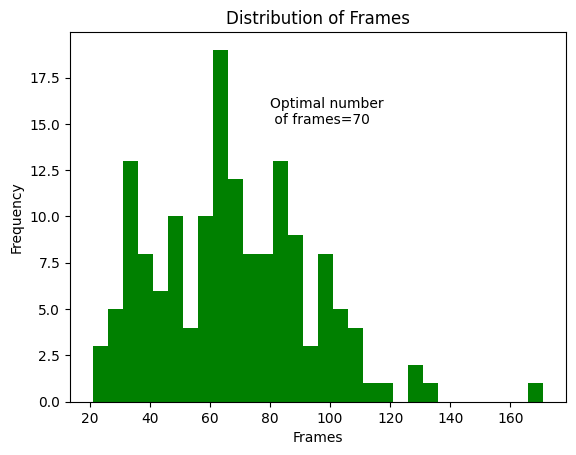

In [22]:
# Plot distribution frames 
plt.title("Distribution of Frames")
plt.xlabel('Frames')
plt.ylabel('Frequency')
plt.hist(pd.DataFrame(n_frames), bins=30, color="g", stacked=True);
plt.text(80, 15, f'Optimal number \n of frames=70');

In [23]:
# Function to retrieve words, video, frames

def words_video(word):
    w = frames_words[frames_words['action'] == word].reset_index()
    return w


In [24]:
words_video("cochlear implant")

,index,action,video_id,frames
0,16,cochlear implant,65373,57.0
1,17,cochlear implant,11498,98.0
2,18,cochlear implant,11499,33.0
3,19,cochlear implant,11500,32.0
4,20,cochlear implant,11501,128.0
5,21,cochlear implant,11502,65.0
6,22,cochlear implant,11503,33.0
7,23,cochlear implant,11504,50.0


## Data Points - New

#### Model Plan A - with loop

In [20]:
# # ---------------------------------------------------
# # Function to extract data points
# # Action = word
# # Folder = /word/number_folder
# # Video_id = name of the video
# # ---------------------------------------------------


# def extract_datapoints(action, folder, video_id, frames):
    
#     data_path = os.path.join('../MP_Data')
    
#     with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

#         for frame_num in range(frames):

#                     # Read feed
#                     ret, frame = cap.read()

#                     # Make detections
#                     try:
#                         image, results = mediapipe_detection(frame, holistic)
#                         print(results)

#                         # Draw landmarks and text
#                         draw_styled_landmarks(image, results)
#                         cv2.putText(image, 'Frames for {} video {}'.format(action, folder), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 0, 255), 1, cv2.LINE_AA)

#                         # Show to screen
#                         cv2.imshow('OpenCV Feed', image)
#                         cv2.waitKey(500)

#                         # Export keypoints
#                         keypoints = extract_keypoints(results)
#                         npy_path = os.path.join(data_path, action, folder, str(frame_num))
#                         np.save(npy_path, keypoints)

#                         # Break gracefully
#                         if cv2.waitKey(10) & 0xFF == ord('q'):
#                             break
#                     except:
#                         pass

In [28]:
# # ---------------------------------------------------
# # Loop to extract data points using function
# # ---------------------------------------------------

# selected_word = ["pregnant"]

# for word in selected_word:
            
#     # Filter the dataframe
#     df_temp = frames_words[frames_words["action"] == word] 

#     # Get information for each action
#     for word in range(0, len(df_temp.action)):

#         action = df_temp.iloc[word, 0]
#         cap = cv2.VideoCapture(f"../raw_data/{df_temp.iloc[word, 1]}.mp4")
#         sequence_folder = word
#         frames = [int(df_temp.iloc[word, 2]) if int(df_temp.iloc[word, 2]) < 70 else 70][0]

#         # Call the function to extract data points
#         extract_datapoints(action, str(sequence_folder), cap, frames)

#### Model  - Plan B 

In [28]:
# #GIO'S METHOD

# # Set mediapipe model 

# cap = cv2.VideoCapture(f'../raw_data/40807.mp4') # Video exemplo muito curto - 50 frames dá erro!


# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     data_path = os.path.join('../MP_Data')
    
#     for frame_num in range(22):

#                 # Read feed
            
#                 ret, frame = cap.read()

#                 # Make detections
#                 image, results = mediapipe_detection(frame, holistic)
#                 print(results)
                
#                 # Draw landmarks
#                 draw_styled_landmarks(image, results)
                
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format("teste", 1), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 0, 255), 1, cv2.LINE_AA)
                
#                  # Show to screen
#                 cv2.imshow('OpenCV Feed', image)
#                 cv2.waitKey(500)
                
                
#                 # Export keypoints
#                 keypoints = extract_keypoints(results)
#                 npy_path = os.path.join(data_path, "teste", str(1), str(frame_num))
#                 np.save(npy_path, keypoints)

#                 # Break gracefully
#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break

#### Model - Plan C

In [25]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('../MP_Data_Web') 

# Actions that we try to detect
actions = np.array(['headache', 'diabetes', 'pregnant', 'tired', 'sore throat', 'infection'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [26]:
# #Create Folders for Keypoint Collection

# for action in actions: 
#     for sequence in range(no_sequences):
#         try: 
#             os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
#         except:
#             pass

In [27]:
pwd

'/Users/pr/code/pariosur/sign-language-translator/notebooks'

In [29]:
# cap = cv2.VideoCapture(0)
# # Set mediapipe model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     # NEW LOOP
#     # Loop through actions
#     for action in actions:
#         # Loop through sequences aka videos
#         for sequence in range(no_sequences):
#             # Loop through video length aka sequence length
#             for frame_num in range(sequence_length):

#                 # Read feed
#                 ret, frame = cap.read()

#                 # Make detections
#                 image, results = mediapipe_detection(frame, holistic)
# #                 print(results)

#                 # Draw landmarks
#                 draw_styled_landmarks(image, results)
                
#                 # NEW Apply wait logic
#                 if frame_num == 0: 
#                     cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     # Show to screen
#                     cv2.imshow('OpenCV Feed', image)
#                     cv2.waitKey(2000)
#                 else: 
#                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     # Show to screen
#                     cv2.imshow('OpenCV Feed', image)
                
#                 # NEW Export keypoints
#                 keypoints = extract_keypoints(results)
#                 npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
#                 np.save(npy_path, keypoints)

#                 # Break gracefully
#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break
                    


In [30]:
cap.release()
cv2.destroyAllWindows()

### Np array comparison

In [85]:
# Sem loop
for i in range(0, 25):
    print(np.load(f"../MP_Data_Web/diabetes/4/{i}.npy"))

[ 0.53295231  0.31829122 -0.45260185 ...  0.42045969  1.04754364
 -0.00419116]
[ 0.51116818  0.27125806 -0.45327982 ...  0.50023282  0.45440137
 -0.02977079]
[ 0.51226205  0.26701719 -0.56076562 ...  0.51803833  0.44634205
 -0.0194762 ]
[ 0.51403314  0.25897917 -0.65930068 ...  0.52956831  0.41472629
 -0.03283573]
[ 0.51537859  0.26702312 -0.69838858 ...  0.54445004  0.41845506
 -0.0395162 ]
[ 0.51594794  0.27379134 -0.63690174 ...  0.5453245   0.39875603
 -0.03759411]
[ 0.52058345  0.27798456 -0.60465229 ...  0.53387535  0.45690224
 -0.01783114]
[ 0.52611959  0.27962875 -0.60019094 ...  0.54016072  0.46221361
 -0.02119835]
[ 0.53048086  0.28059083 -0.62918162 ...  0.54168367  0.46591797
 -0.02221189]
[ 0.53138638  0.28084055 -0.6765511  ...  0.54480088  0.43291438
 -0.02757672]
[ 0.53163701  0.2813389  -0.68380642 ...  0.55847979  0.46986577
 -0.05475879]
[ 0.53231394  0.28144535 -0.65162379 ...  0.55568326  0.52652496
 -0.0430311 ]
[ 0.53516412  0.28161177 -0.64645535 ...  0.47262865

In [28]:
# # Com loop
# for i in range(5, 15):
#     print(np.load(f"../MP_Data/teste/1/{i}.npy"))

## Extract Data Points - Old

### Extract data points from videos

In [29]:
# # ---------------------------------------------------
# #  Function to extract data points from videos
# #  Action = words
# #  Video_id = name of the video
# #  Sequence = folder in which it will be placed
# # ---------------------------------------------------

# def extract_data_points(action, video_id, folder):
    
#     with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

#         for frame_num in range(sequence_length):
            
#             sequence = 1

#             # Read feed
#             cap = cv2.VideoCapture(f'../raw_data/{video_id}.mp4')
#             ret, frame = cap.read()

#             # Make detections
#             image, results = mediapipe_detection(frame, holistic)
#             print(results)

#             # Draw landmarks
#             draw_styled_landmarks(image, results)

#             # Apply wait logic
#             if frame_num == 0: 
#                 cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

#                 # Show to screen
#                 cv2.imshow('OpenCV Feed', image)
#                 cv2.waitKey(2000)
#             else: 
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                 # Show to screen
#                 cv2.imshow('OpenCV Feed', image)

#             # Export keypoints
#             keypoints = extract_keypoints(results)
#             npy_path = os.path.join(DATA_PATH, action, str(folder), str(frame_num))
#             np.save(npy_path, keypoints)

#             # Break gracefully
#             if cv2.waitKey(10) & 0xFF == ord('q'):
#                 break

In [30]:
# # ---------------------------------------------------
# # Loop to extract data points for each word and video
# # and save it in the correct folder
# # ---------------------------------------------------

# for word in id_list.word.unique():
    
#     if word == "tired": #apagar depois dos testes, filtra apenas 1 palavra
        
#         # Filter the dataframe
#         df_temp = id_list[id_list["word"] == word] 

#         # Get information for each action
#         for word in range(0, len(df_temp.word)):

#             action = df_temp.iloc[word, 0]
#             video_id = df_temp.iloc[word, 1]
#             sequence = word

#             # Call the function to extract data points
#             extract_data_points(action, video_id, sequence)

### Extract data points from webcam

In [24]:
# ---------------------------------------------------
# Function to extract data points from webcam to
# complement actions with less than x videos. This
# function also creates additional folders

# Action = list of words
# no_sequence = number of additional videos to create
# ---------------------------------------------------

def extract_data_points_webcam(actions, no_sequences):
    
    # Extract video from webcam
    cap = cv2.VideoCapture(0)
    
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        # Loop through actions
        for action in actions:
            
            #Identify number of folders for this action
            start_folder = int(max(os.listdir(f"../MP_Data/{action}")))+1
            
            # Loop through sequences aka videos
            for sequence in range(start_folder, start_folder+no_sequences):
                
                # Create folder before export
                os.makedirs(os.path.join(DATA_PATH, action, str(sequence))) 
                
                # Loop through video length aka sequence length
                for frame_num in range(sequence_length):

                    # Read feed
                    ret, frame = cap.read()

                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    draw_styled_landmarks(image, results)

                    # Apply wait logic
                    if frame_num == 0: 
                        cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(500)
                    else: 
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)

                    # Export keypoints
                    keypoints = extract_keypoints(results)                    
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)

                    # Break gracefully
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break

        cap.release()
        cv2.destroyAllWindows()
                    

In [41]:
# # ---------------------------------------------------
# # Create additional videos for selected words
# # ---------------------------------------------------

# list_words = ['vomit']
# extract_data_points_webcam(list_words, 5)


## Data Augmentation

In [2]:
!pip install git+https://github.com/okankop/vidaug

  Cloning https://github.com/okankop/vidaug to /private/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/pip-req-build-9fevg1xn
  Running command git clone -q https://github.com/okankop/vidaug /private/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/pip-req-build-9fevg1xn
You should consider upgrading via the '/Users/pr/.pyenv/versions/3.8.12/envs/sign-language-translator/bin/python -m pip install --upgrade pip' command.


In [3]:
from vidaug import augmentors as va


ModuleNotFoundError: No module named 'vidaug'

## Preprocess Data and Create Labels and Features

In [86]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [87]:
label_map = {label:num for num, label in enumerate(actions)}


In [88]:
label_map

{'headache': 0,
 'diabetes': 1,
 'pregnant': 2,
 'tired': 3,
 'sore throat': 4,
 'infection': 5}

In [89]:
# no_videos = 3
# seq_lenght_test = 30

In [90]:
np.load('/Users/pr/code/pariosur/sign-language-translator/MP_Data_Web/tired/0/3.npy')

array([ 0.54174018,  0.28855076, -0.60200274, ...,  0.        ,
        0.        ,  0.        ])

In [91]:
np.load('/Users/pr/code/pariosur/sign-language-translator/MP_Data_Web/tired/0/4.npy')

array([ 0.52520257,  0.23057598, -0.50659865, ...,  0.4024156 ,
        0.78690308, -0.00830284])

In [92]:
aux_list.video_id

0      7
1      5
2      4
3      8
4     13
5      8
6      6
7      6
8      7
9     10
10    10
11     6
12     7
13     6
14     6
15     6
16     7
17     8
18     6
19     8
20    10
Name: video_id, dtype: int64

In [95]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [96]:
np.array(sequences).shape


(180, 30, 1662)

In [97]:
np.array(labels).shape


(180,)

In [98]:
X = np.array(sequences)
X.shape

(180, 30, 1662)

In [99]:
y = to_categorical(labels).astype(int)
y


array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

BREAK

In [100]:
np.array(sequences).shape

(180, 30, 1662)

In [101]:
np.array(labels).shape

(180,)

In [102]:
X = np.array(sequences)
X.shape

(180, 30, 1662)

In [103]:
y = to_categorical(labels).astype(int)


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)


In [105]:
y_test.shape


(9, 6)

## Build and Train LSTM Neural Network

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Masking
from tensorflow.keras.callbacks import EarlyStopping

In [107]:
log_dir = os.path.join('Logs_Web')
tb_callback = TensorBoard(log_dir=log_dir)

2022-09-05 10:54:39.401989: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-05 10:54:39.402062: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-05 10:54:39.403407: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Model 1

In [108]:
model = Sequential()
model.add(GRU(32, return_sequences=False, activation='relu', input_shape=(30,1662)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [109]:
actions.shape[0]

6

In [153]:
res = [.7, 0.9, 0.95, 0.1, 0.1, 0.1]
res

[0.7, 0.9, 0.95, 0.1, 0.1, 0.1]

In [154]:
actions[np.argmax(res)]


'pregnant'

In [112]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [113]:
es = EarlyStopping(patience=500, restore_best_weights=True)
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback,es], validation_split = 0.3, batch_size = 16)


Epoch 1/2000
3/8 [==========>...................] - ETA: 0s - loss: 2.0215 - categorical_accuracy: 0.1250  

2022-09-05 10:54:45.912844: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-05 10:54:45.912864: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-05 10:54:45.987065: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-05 10:54:46.000977: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-09-05 10:54:46.014952: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs_Web/train/plugins/profile/2022_09_05_10_54_46
2022-09-05 10:54:46.022584: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs_Web/train/plugins/profile/2022_09_05_10_54_46/Pablos-MacBook-Pro.local.trace.json.gz
2022-09-05 10:54:46.032587: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs_Web/train/plugins/profile/2022_09_05_10_54_46
2022-09

8/8 [==============================] - 1s 74ms/step - loss: 1.9340 - categorical_accuracy: 0.1513 - val_loss: 2.0612 - val_categorical_accuracy: 0.0769
Epoch 2/2000
8/8 [==============================] - 0s 12ms/step - loss: 1.7953 - categorical_accuracy: 0.2017 - val_loss: 1.9523 - val_categorical_accuracy: 0.0769
Epoch 3/2000
8/8 [==============================] - 0s 12ms/step - loss: 1.7678 - categorical_accuracy: 0.2101 - val_loss: 1.7861 - val_categorical_accuracy: 0.1731
Epoch 4/2000
8/8 [==============================] - 0s 11ms/step - loss: 1.7693 - categorical_accuracy: 0.1849 - val_loss: 1.8190 - val_categorical_accuracy: 0.0769
Epoch 5/2000
8/8 [==============================] - 0s 12ms/step - loss: 1.7271 - categorical_accuracy: 0.2521 - val_loss: 1.8335 - val_categorical_accuracy: 0.0769
Epoch 6/2000
8/8 [==============================] - 0s 11ms/step - loss: 1.7117 - categorical_accuracy: 0.2185 - val_loss: 1.8555 - val_categorical_accuracy: 0.0769
Epoch 7/2000
8/8 [=====

8/8 [==============================] - 0s 11ms/step - loss: 0.5572 - categorical_accuracy: 0.7899 - val_loss: 0.6569 - val_categorical_accuracy: 0.6923
Epoch 51/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.5991 - categorical_accuracy: 0.6975 - val_loss: 0.8343 - val_categorical_accuracy: 0.6154
Epoch 52/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.6976 - categorical_accuracy: 0.7227 - val_loss: 0.7880 - val_categorical_accuracy: 0.5577
Epoch 53/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.5989 - categorical_accuracy: 0.7059 - val_loss: 0.7918 - val_categorical_accuracy: 0.7500
Epoch 54/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.5248 - categorical_accuracy: 0.7815 - val_loss: 0.7114 - val_categorical_accuracy: 0.6923
Epoch 55/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.6204 - categorical_accuracy: 0.7059 - val_loss: 0.4494 - val_categorical_accuracy: 0.8654
Epoch 56/2000
8/8 

8/8 [==============================] - 0s 11ms/step - loss: 0.1829 - categorical_accuracy: 0.9580 - val_loss: 0.4398 - val_categorical_accuracy: 0.8654
Epoch 100/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2732 - categorical_accuracy: 0.9076 - val_loss: 1.8335 - val_categorical_accuracy: 0.4038
Epoch 101/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.8088 - categorical_accuracy: 0.6975 - val_loss: 0.1932 - val_categorical_accuracy: 0.9615
Epoch 102/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1401 - categorical_accuracy: 0.9832 - val_loss: 0.3688 - val_categorical_accuracy: 0.8269
Epoch 103/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1800 - categorical_accuracy: 0.9412 - val_loss: 0.3904 - val_categorical_accuracy: 0.8654
Epoch 104/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.2741 - categorical_accuracy: 0.9160 - val_loss: 0.5613 - val_categorical_accuracy: 0.7500
Epoch 105/200

8/8 [==============================] - 0s 11ms/step - loss: 0.1226 - categorical_accuracy: 0.9412 - val_loss: 1.1369 - val_categorical_accuracy: 0.6154
Epoch 149/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.3384 - categorical_accuracy: 0.8908 - val_loss: 0.1969 - val_categorical_accuracy: 0.9423
Epoch 150/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0319 - categorical_accuracy: 1.0000 - val_loss: 0.0925 - val_categorical_accuracy: 0.9615
Epoch 151/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0371 - categorical_accuracy: 1.0000 - val_loss: 0.3318 - val_categorical_accuracy: 0.8462
Epoch 152/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.4336 - categorical_accuracy: 0.8319 - val_loss: 0.9838 - val_categorical_accuracy: 0.7308
Epoch 153/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1189 - categorical_accuracy: 0.9664 - val_loss: 0.2304 - val_categorical_accuracy: 0.9038
Epoch 154/200

8/8 [==============================] - 0s 11ms/step - loss: 0.1858 - categorical_accuracy: 0.9412 - val_loss: 0.1691 - val_categorical_accuracy: 0.9615
Epoch 198/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0149 - categorical_accuracy: 1.0000 - val_loss: 0.1364 - val_categorical_accuracy: 0.9808
Epoch 199/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0064 - categorical_accuracy: 1.0000 - val_loss: 0.1191 - val_categorical_accuracy: 0.9808
Epoch 200/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0048 - categorical_accuracy: 1.0000 - val_loss: 0.1671 - val_categorical_accuracy: 0.9808
Epoch 201/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.4557 - categorical_accuracy: 0.9160 - val_loss: 0.8169 - val_categorical_accuracy: 0.8269
Epoch 202/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1398 - categorical_accuracy: 0.9496 - val_loss: 0.2078 - val_categorical_accuracy: 0.9423
Epoch 203/200

8/8 [==============================] - 0s 11ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 0.2452 - val_categorical_accuracy: 0.9423
Epoch 247/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 0.2264 - val_categorical_accuracy: 0.9423
Epoch 248/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 0.2267 - val_categorical_accuracy: 0.9423
Epoch 249/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 0.2423 - val_categorical_accuracy: 0.9423
Epoch 250/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.3538 - categorical_accuracy: 0.9496 - val_loss: 3.9136 - val_categorical_accuracy: 0.5577
Epoch 251/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.7816 - categorical_accuracy: 0.8908 - val_loss: 0.8681 - val_categorical_accuracy: 0.7308
Epoch 252/200

Epoch 295/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0118 - categorical_accuracy: 1.0000 - val_loss: 0.3407 - val_categorical_accuracy: 0.9231
Epoch 296/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.3235 - val_categorical_accuracy: 0.9231
Epoch 297/2000
8/8 [==============================] - 0s 11ms/step - loss: 7.9667e-04 - categorical_accuracy: 1.0000 - val_loss: 0.3041 - val_categorical_accuracy: 0.9231
Epoch 298/2000
8/8 [==============================] - 0s 11ms/step - loss: 6.2183e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2792 - val_categorical_accuracy: 0.9231
Epoch 299/2000
8/8 [==============================] - 0s 11ms/step - loss: 4.8200e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2679 - val_categorical_accuracy: 0.9231
Epoch 300/2000
8/8 [==============================] - 0s 11ms/step - loss: 3.9007e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2605 - val_categorical

8/8 [==============================] - 0s 13ms/step - loss: 0.0407 - categorical_accuracy: 0.9832 - val_loss: 0.2172 - val_categorical_accuracy: 0.9615
Epoch 344/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0066 - categorical_accuracy: 1.0000 - val_loss: 0.2728 - val_categorical_accuracy: 0.9231
Epoch 345/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0032 - categorical_accuracy: 1.0000 - val_loss: 0.2382 - val_categorical_accuracy: 0.9423
Epoch 346/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0019 - categorical_accuracy: 1.0000 - val_loss: 0.2520 - val_categorical_accuracy: 0.9231
Epoch 347/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 0.2531 - val_categorical_accuracy: 0.9423
Epoch 348/2000
8/8 [==============================] - 0s 12ms/step - loss: 7.9362e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2205 - val_categorical_accuracy: 0.9615
Epoch 349

8/8 [==============================] - 0s 11ms/step - loss: 0.0020 - categorical_accuracy: 1.0000 - val_loss: 0.2442 - val_categorical_accuracy: 0.9423
Epoch 392/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 0.2002 - val_categorical_accuracy: 0.9808
Epoch 393/2000
8/8 [==============================] - 0s 11ms/step - loss: 6.7691e-04 - categorical_accuracy: 1.0000 - val_loss: 0.1896 - val_categorical_accuracy: 0.9808
Epoch 394/2000
8/8 [==============================] - 0s 10ms/step - loss: 4.4614e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2190 - val_categorical_accuracy: 0.9615
Epoch 395/2000
8/8 [==============================] - 0s 11ms/step - loss: 2.6898e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2433 - val_categorical_accuracy: 0.9615
Epoch 396/2000
8/8 [==============================] - 0s 11ms/step - loss: 2.1704e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2272 - val_categorical_accuracy: 0.96

8/8 [==============================] - 0s 12ms/step - loss: 1.9040e-05 - categorical_accuracy: 1.0000 - val_loss: 0.4079 - val_categorical_accuracy: 0.9231
Epoch 440/2000
8/8 [==============================] - 0s 12ms/step - loss: 1.5996e-05 - categorical_accuracy: 1.0000 - val_loss: 0.3783 - val_categorical_accuracy: 0.9423
Epoch 441/2000
8/8 [==============================] - 0s 11ms/step - loss: 1.3808e-05 - categorical_accuracy: 1.0000 - val_loss: 0.4893 - val_categorical_accuracy: 0.8846
Epoch 442/2000
8/8 [==============================] - 0s 11ms/step - loss: 1.5703 - categorical_accuracy: 0.7815 - val_loss: 0.3863 - val_categorical_accuracy: 0.8462
Epoch 443/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1019 - categorical_accuracy: 0.9748 - val_loss: 0.4321 - val_categorical_accuracy: 0.8846
Epoch 444/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0252 - categorical_accuracy: 0.9916 - val_loss: 0.3014 - val_categorical_accuracy: 0.9231
E

8/8 [==============================] - 0s 11ms/step - loss: 0.0020 - categorical_accuracy: 1.0000 - val_loss: 0.2522 - val_categorical_accuracy: 0.9423
Epoch 488/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0017 - categorical_accuracy: 1.0000 - val_loss: 0.2085 - val_categorical_accuracy: 0.9615
Epoch 489/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 0.2206 - val_categorical_accuracy: 0.9615
Epoch 490/2000
8/8 [==============================] - 0s 11ms/step - loss: 8.2189e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2175 - val_categorical_accuracy: 0.9615
Epoch 491/2000
8/8 [==============================] - 0s 11ms/step - loss: 5.8933e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2389 - val_categorical_accuracy: 0.9615
Epoch 492/2000
8/8 [==============================] - 0s 11ms/step - loss: 4.6198e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2068 - val_categorical_accuracy: 0.9615
E

8/8 [==============================] - 0s 11ms/step - loss: 0.0705 - categorical_accuracy: 0.9832 - val_loss: 0.6095 - val_categorical_accuracy: 0.9038
Epoch 536/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.0032 - categorical_accuracy: 1.0000 - val_loss: 0.5953 - val_categorical_accuracy: 0.8846
Epoch 537/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 0.6104 - val_categorical_accuracy: 0.8846
Epoch 538/2000
8/8 [==============================] - 0s 11ms/step - loss: 8.7790e-04 - categorical_accuracy: 1.0000 - val_loss: 0.5933 - val_categorical_accuracy: 0.9038
Epoch 539/2000
8/8 [==============================] - 0s 11ms/step - loss: 6.2847e-04 - categorical_accuracy: 1.0000 - val_loss: 0.5678 - val_categorical_accuracy: 0.8846
Epoch 540/2000
8/8 [==============================] - 0s 11ms/step - loss: 4.1982e-04 - categorical_accuracy: 1.0000 - val_loss: 0.5660 - val_categorical_accuracy: 0.8846
E

8/8 [==============================] - 0s 12ms/step - loss: 4.4944e-05 - categorical_accuracy: 1.0000 - val_loss: 0.2502 - val_categorical_accuracy: 0.9808
Epoch 584/2000
8/8 [==============================] - 0s 11ms/step - loss: 4.1583e-05 - categorical_accuracy: 1.0000 - val_loss: 0.2573 - val_categorical_accuracy: 0.9808
Epoch 585/2000
8/8 [==============================] - 0s 11ms/step - loss: 3.1861e-05 - categorical_accuracy: 1.0000 - val_loss: 0.2473 - val_categorical_accuracy: 0.9808
Epoch 586/2000
8/8 [==============================] - 0s 11ms/step - loss: 2.4620e-05 - categorical_accuracy: 1.0000 - val_loss: 0.2493 - val_categorical_accuracy: 0.9808
Epoch 587/2000
8/8 [==============================] - 0s 11ms/step - loss: 1.9978e-05 - categorical_accuracy: 1.0000 - val_loss: 0.2377 - val_categorical_accuracy: 0.9808
Epoch 588/2000
8/8 [==============================] - 0s 11ms/step - loss: 1.7761e-05 - categorical_accuracy: 1.0000 - val_loss: 0.2367 - val_categorical_accura

8/8 [==============================] - 0s 12ms/step - loss: 2.3012e-04 - categorical_accuracy: 1.0000 - val_loss: 0.9483 - val_categorical_accuracy: 0.9423
Epoch 632/2000
8/8 [==============================] - 0s 11ms/step - loss: 1.7782e-04 - categorical_accuracy: 1.0000 - val_loss: 0.9420 - val_categorical_accuracy: 0.9615
Epoch 633/2000
8/8 [==============================] - 0s 11ms/step - loss: 1.6578e-04 - categorical_accuracy: 1.0000 - val_loss: 0.9205 - val_categorical_accuracy: 0.9615
Epoch 634/2000
8/8 [==============================] - 0s 11ms/step - loss: 8.8179e-05 - categorical_accuracy: 1.0000 - val_loss: 0.9275 - val_categorical_accuracy: 0.9615
Epoch 635/2000
8/8 [==============================] - 0s 12ms/step - loss: 7.7345e-05 - categorical_accuracy: 1.0000 - val_loss: 0.9005 - val_categorical_accuracy: 0.9808
Epoch 636/2000
8/8 [==============================] - 0s 12ms/step - loss: 5.6946e-05 - categorical_accuracy: 1.0000 - val_loss: 0.9134 - val_categorical_accura

In [114]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                162816    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 163,446
Trainable params: 163,446
Non-trainable params: 0
_________________________________________________________________


### Load Tensorboard

In [115]:

%load_ext tensorboard
%tensorboard --logdir '..notebooks/Logs/train'
%reload_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Make Predictions


In [116]:
res = model.predict(X_test)

In [117]:
actions[np.argmax(res[4])]


'sore throat'

In [118]:
actions[np.argmax(y_test[4])]


'sore throat'

## Save Weights


In [155]:
yhat = model.predict(X_test)


In [156]:
model.save('action.h5')


In [157]:
model.load_weights('action.h5')


## Evaluation using Confusion Matrix and Accuracy


In [122]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [123]:
yhat = model.predict(X_test)


In [124]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [125]:
multilabel_confusion_matrix(ytrue, yhat)


array([[[7, 0],
        [0, 2]],

       [[8, 0],
        [0, 1]],

       [[7, 0],
        [0, 2]],

       [[6, 0],
        [0, 3]],

       [[8, 0],
        [0, 1]]])

In [126]:
accuracy_score(ytrue, yhat)


1.0

## Test in Real Time


In [127]:
colors = [(245,117,16), (117,245,16), (16,117,245), (115,11,145), (245,171,45), (5,11,135)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [128]:
len(res)

9

In [129]:
sentence

['diabetes']

In [158]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 6: 
                sentence = sentence[-6:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (6,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_

<class 'mediapipe.python.solution_base.SolutionOutputs'>
diabetes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
diabetes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
diabetes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
diabetes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
diabetes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
diabetes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
diabetes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
diabetes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
diabetes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
diabetes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<clas

<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection


In [140]:
sequence

[array([ 0.60773981,  0.4508433 , -0.92502433, ...,  0.45084435,
         0.96354306,  0.0657717 ]),
 array([ 0.58618474,  0.4397524 , -0.88151586, ...,  0.38762954,
         1.13290226, -0.03256255]),
 array([ 0.558056  ,  0.42719889, -0.60135275, ...,  0.24267533,
         0.69222003, -0.04825592]),
 array([ 0.53125012,  0.42861897, -0.68392795, ...,  0.31941336,
         0.45209676, -0.02794245]),
 array([ 0.52229834,  0.42360374, -0.52126753, ...,  0.33957756,
         0.38985053, -0.02372184]),
 array([ 0.51909447,  0.42107722, -0.51464385, ...,  0.34751576,
         0.37565967, -0.02095989]),
 array([ 0.52021706,  0.41868383, -0.48386779, ...,  0.34952521,
         0.3746143 , -0.01606832]),
 array([ 0.52149326,  0.4158724 , -0.4915387 , ...,  0.35157722,
         0.37459195, -0.01394615]),
 array([ 0.52547055,  0.41233593, -0.48081955, ...,  0.35337508,
         0.37636834, -0.01203678]),
 array([ 0.52555567,  0.4101969 , -0.48773989, ...,  0.35514238,
         0.37785262, -0.01

In [134]:
print(actions[np.argmax(res)])

infection


In [144]:
cap.release()
cv2.destroyAllWindows()

In [136]:
len(sequence)

30

In [142]:
model.predict(np.expand_dims(X_test[0], axis=0))


array([[9.9893111e-01, 7.7048322e-04, 2.2685432e-08, 1.2395362e-08,
        1.7002609e-05, 2.8147042e-04]], dtype=float32)

In [159]:
type(model)

tensorflow.python.keras.engine.sequential.Sequential

In [161]:
from tensorflow.keras.models import save_model

save_model(model, "action_model.hdf5")